## Importing required libraries

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import random
import os

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision

import torchvision.transforms as transforms

import time

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score

from typing import Literal

## Rocket class

In [ ]:
def _set_random_seed(seed):
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        os.environ['PYTHONHASHSEED'] = str(seed)


def _generate_kernels(in_channels, input_size, out_channels, convolution_type, use_bias) -> dict:
    groups = {}

    candidate_sizes = np.array((3, 5, 7), dtype=np.int32)
    # Indices of kernel with padding
    candidate_pad = np.random.randint(2, size=out_channels) == 1

    # Generate random kernel sizes
    sizes = np.random.choice(candidate_sizes, out_channels)

    # Generate dilations and paddings
    dilations = np.zeros(out_channels)
    paddings = np.zeros(out_channels)
    for size in candidate_sizes:
        num_ker = (sizes == size).sum()
        if num_ker > 0:
            # Generate dilations
            dilations[sizes == size] = 2 ** np.random.uniform(
                0, np.log2((input_size - 1) / (size - 1)), size=num_ker)
            dilations[sizes == size] = np.int32(dilations[sizes == size])

            # Generate paddings
            paddings[(sizes == size) & candidate_pad] = (
                (size - 1) * dilations[(sizes == size) & candidate_pad]) // 2

    # Grouping kernel by key: <kernel_size, dilation, padding>
    kernel_params = np.stack(
        [sizes, dilations, paddings], axis=1).astype(np.int32)
    unique_params, counts = np.unique(
        kernel_params, axis=0, return_counts=True)

    for key, c in zip(unique_params, counts):

        # Generate random biases
        bias = None
        if use_bias:
            if convolution_type == "depthwise":
                bias = np.random.uniform(-1, 1, c *
                                         in_channels).astype(np.float32)
            else:
                bias = np.random.uniform(-1, 1, c).astype(np.float32)
            bias = torch.from_numpy(bias)

        groups[tuple(key.tolist())] = {
            "weights": _generate_weights(c, in_channels, key[0], convolution_type),
            "bias": bias,
        }

    return groups


def _generate_weights(out_channels, in_channels, kernel_size, convolution_type=None):

    if convolution_type == "spatial":
        # horizontal kernels
        weights_1 = np.random.normal(
            0, 1, (out_channels, in_channels, 1, kernel_size)).astype(np.float32)
        weights_1 = weights_1 - weights_1.mean(axis=(2, 3), keepdims=True)

        # vertical kernels
        weights_2 = np.random.normal(
            0, 1, (out_channels, out_channels, kernel_size, 1)).astype(np.float32)
        weights_2 = weights_2 - weights_2.mean(axis=(2, 3), keepdims=True)

        return torch.from_numpy(weights_1), torch.from_numpy(weights_2)

    elif convolution_type == "depthwise_sep":
        # depthwise kernels
        weights_1 = np.random.normal(
            0, 1, (in_channels, 1, kernel_size, kernel_size)).astype(np.float32)
        weights_1 = weights_1 - weights_1.mean(axis=(2, 3), keepdims=True)

        # pointwise kernels
        weights_2 = np.random.normal(
            0, 1, (out_channels, in_channels, 1, 1)).astype(np.float32)
        weights_2 = weights_2 - weights_2.mean(axis=(2, 3), keepdims=True)

        return torch.from_numpy(weights_1), torch.from_numpy(weights_2)

    elif convolution_type == "depthwise":
        # depthwise kernels
        weights_1 = np.random.normal(
            0, 1, (out_channels * in_channels, 1, kernel_size, kernel_size)).astype(np.float32)
        weights_1 = weights_1 - weights_1.mean(axis=(2, 3), keepdims=True)

        return torch.from_numpy(weights_1),

    else:
        weights = np.random.normal(
            0, 1, (out_channels, in_channels, kernel_size, kernel_size)).astype(np.float32)
        weights = weights - weights.mean(axis=(2, 3), keepdims=True)

        return torch.from_numpy(weights),


class ROCKET(BaseEstimator, TransformerMixin):
    def __init__(self, out_channels=10000, convolution_type: Literal['standard', 'spatial', 'depthwise_sep', 'depthwise'] = 'standard', use_bias: bool = True, random_state=None):
        self.out_channels = out_channels
        self.conv_params = {}
        self.convolution_type = convolution_type
        self.random_state = random_state if isinstance(
            random_state, int) else None
        self.use_bias = use_bias

        if self.random_state is not None:
            _set_random_seed(self.random_state)

    def fit(self, X, y=None):
        _, in_channels, _, input_size = X.shape
        self.conv_params = _generate_kernels(
            in_channels, input_size, self.out_channels, self.convolution_type, self.use_bias)

    def transform(self, X):
        batch_size, in_channels, _, input_size = X.shape

        # [B, out_channels]
        features = torch.zeros((batch_size, self.out_channels))

        s = 0
        for (kernel_size, dilation, padding), var in self.conv_params.items():

            output_length = (input_size + (2 * padding)
                             ) - ((kernel_size - 1) * dilation)

            if self.convolution_type == "spatial":
                padding_1, padding_2 = (0, padding), (padding, 0)
                dilation_1, dilation_2 = (1, dilation), (dilation, 1)
                group = 1
            elif self.convolution_type == "depthwise_sep":
                padding_1, padding_2 = (padding, padding), 0
                dilation_1, dilation_2 = (dilation, dilation), 1
                group = in_channels
            elif self.convolution_type == "depthwise":
                padding_1 = (padding, padding)
                dilation_1 = (dilation, dilation)
                group = in_channels
            else:
                padding_1 = (padding, padding)
                dilation_1 = (dilation, dilation)
                group = 1

            # First convolution
            data = F.conv2d(
                input=X,
                weight=var['weights'][0],
                bias=var['bias'] if self.convolution_type in [
                    "standard", "depthwise"] else None,
                stride=1,
                padding=padding_1,
                dilation=dilation_1,
                groups=group
            )

            # Second convolution if convolution_type requires it
            if self.convolution_type in ["spatial", "depthwise_sep"]:
                data = F.conv2d(
                    input=data,
                    weight=var['weights'][1],
                    bias=var['bias'],
                    stride=1,
                    padding=padding_2,
                    dilation=dilation_2,
                    groups=1
                )

            if self.convolution_type == "depthwise":
                kernel_per_layer = var['weights'][0].shape[0] // in_channels
                ppv = torch.zeros(
                    (batch_size, kernel_per_layer))
                for i in range(kernel_per_layer):
                    ppv[:, i] = (data[:, i::kernel_per_layer] > 0).sum(
                        dim=(1, 2, 3)) / output_length

            else:
                # Computing the features: PPV
                ppv = (data > 0).sum(dim=(2, 3)) / \
                    output_length  # [B, num_kernel_group]

            e = s + ppv.shape[1]
            features[:, s:e] = ppv
            s = e

        return features


## Loading and preprocessing the dataset

In [4]:
batch_size = 128

transform_train = transforms.Compose(
                                    [
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
                                    )
            
transform_test = transforms.Compose(
						[
						transforms.ToTensor(),
						transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
						)

train_set = torchvision.datasets.CIFAR10('./data/cifar10/', train = True, transform = transform_train, download = True)


test_set = torchvision.datasets.CIFAR10(root='./data/cifar10/', train=False,
									download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


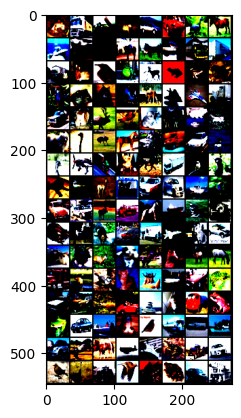

In [5]:
def imshow(img):
   npimg = img.numpy()
   plt.imshow(np.transpose(npimg, (1, 2, 0)))
   plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
labels
# show images
imshow(torchvision.utils.make_grid(images))

## Tranforming the dataset using ROCKET

In [15]:
def transform_dataset(loader, transformer):
	X_list = []

	for X_batch, _ in loader:
		X_batch_transformed = transformer.transform(X_batch)
		X_list.append(X_batch_transformed.cpu())

	return torch.cat(X_list, dim=0).numpy()

In [7]:
y_test = []
for _, y_batch in test_loader:
    y_test.append(y_batch)

y_test = np.concatenate(y_test, axis=0)

y_train = []
for _, y_batch in train_loader:
    y_train.append(y_batch)
y_train = np.concatenate(y_train, axis=0)

## Measuring the performance

In [ ]:
def measure_performance(model, train_loader, test_loader):
    
    start = time.time()
    model.fit(torch.rand(1, 3, 32, 32))  # Dummy fit to initialize parameters
    model_fit_time = time.time() - start

    # Tempo di trasformazione (feature extraction)
    start = time.time()
    X_train_transformed = transform_dataset(train_loader, model)
    transform_time_train = time.time() - start
    start = time.time()
    X_test_transformed = transform_dataset(test_loader, model)
    transform_time_test = time.time() - start
    
    # Tempo di training logistic regression
    start = time.time()
    clf = LogisticRegression(max_iter=15000).fit(X_train_transformed, y_train)
    training_time = time.time() - start

	# Tempo di training ridge regression
    start = time.time()
    ridge = RidgeClassifier(alpha=0.1).fit(X_train_transformed, y_train)
    training_time_ridge = time.time() - start

    # Accuracy logistic regression
    predictions = clf.predict(X_test_transformed)
    acc = accuracy_score(y_test, predictions)

    # Accuracy ridge regression
    predictions_ridge = ridge.predict(X_test_transformed)
    acc_ridge = accuracy_score(y_test, predictions_ridge)

    return {
        'model_fit_time': round(model_fit_time, 3),
		'transform_time_train': round(transform_time_train,3),
		'transform_time_test': round(transform_time_test,3),
		'training_time_logistic': round(training_time,3),
		'accuracy_logistic': acc,
		'training_time_ridge': round(training_time_ridge,3),
		'accuracy_ridge': acc_ridge
	}

In [ ]:
results = []

for conv_type in ['standard', 'spatial', 'depthwise_sep', 'depthwise']:
	for seed in [42, 0, 1]:
		rocket = ROCKET(out_channels=1000, convolution_type=conv_type, random_state=seed)
		res = measure_performance(rocket, train_loader, test_loader)

		results.append({
            **rocket.get_params(),
			**res
        })

df = pd.DataFrame(results)

/Users/lucagrandi/Desktop/roc2img/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 14201 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lucagrandi/Desktop/roc2img/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 14198 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

   convolution_type  out_channels  random_state  use_bias model_fit_time  \
0          standard          1000            42      True          0.012   
1          standard          1000             0      True          0.011   
2          standard          1000             1      True          0.009   
3           spatial          1000            42      True          0.014   
4           spatial          1000             0      True          0.008   
5           spatial          1000             1      True          0.012   
6     depthwise_sep          1000            42      True          0.007   
7     depthwise_sep          1000             0      True          0.002   
8     depthwise_sep          1000             1      True          0.006   
9         depthwise          1000            42      True          0.008   
10        depthwise          1000             0      True          0.020   
11        depthwise          1000             1      True          0.009   

   transfor

In [38]:
df

,convolution_type,out_channels,random_state,use_bias,model_fit_time,transform_time_train,transform_time_test,training_time_logistic,accuracy_logistic,training_time_ridge,accuracy_ridge
0,standard,1000,42,True,0.012,259.853,61.857,740.152,0.6234,0.322,0.6087
1,standard,1000,0,True,0.011,259.202,62.206,777.055,0.6184,0.449,0.6045
2,standard,1000,1,True,0.009,254.598,60.701,673.529,0.6143,0.417,0.6004
3,spatial,1000,42,True,0.014,461.434,101.885,724.617,0.5528,0.316,0.5406
4,spatial,1000,0,True,0.008,446.738,99.872,849.942,0.5473,0.319,0.5446
5,spatial,1000,1,True,0.012,449.907,99.389,732.885,0.5529,0.399,0.5532
6,depthwise_sep,1000,42,True,0.007,340.260,77.859,0.220,0.1000,0.252,0.1000
7,depthwise_sep,1000,0,True,0.002,337.222,78.062,0.281,0.1000,0.253,0.1000
8,depthwise_sep,1000,1,True,0.006,331.618,76.485,0.323,0.1000,0.267,0.1000
9,depthwise,1000,42,True,0.008,597.134,134.712,1427.423,0.6355,0.473,0.6188


In [ ]:
time_columns = ['model_fit_time', 'transform_time_train', 'transform_time_test', 
				'training_time_logistic', 'training_time_ridge']

# Poi procedi con il raggruppamento
df.groupby('convolution_type')[time_columns].mean().round(3)

,model_fit_time,transform_time_train,transform_time_test,training_time_logistic,training_time_ridge
convolution_type,,,,,
depthwise,0.012,609.684,132.094,1386.478,0.384
depthwise_sep,0.005,336.367,77.469,0.275,0.257
spatial,0.011,452.693,100.382,769.148,0.345
standard,0.011,257.884,61.588,730.245,0.396
